<img src="https://10xtravel.com/wp-content/uploads/2021/05/Flight_Delay.png" alt="Alt Text" width="600">
# <h1 align: center> United States Airlines Delay Analysis

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import ttest_1samp,ttest_ind,mannwhitneyu,levene,shapiro
from statsmodels.stats.power import ttest_power
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
airlines = pd.read_excel('Airlines.xlsx')
airports = pd.read_excel('airports.xlsx')
runways = pd.read_excel('runways.xlsx')

In [4]:
print("Airlines dataset size : ")
print(airlines.shape)
print("\nAirports dataset size : ")
print(airports.shape)
print("\nRunways dataset size : ")
print(runways.shape)

Airlines dataset size : 
(518556, 9)

Airports dataset size : 
(73805, 18)

Runways dataset size : 
(43977, 20)


In [5]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [6]:
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [7]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


**Airlines is our target dataset**

In [8]:
airlines.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay'],
      dtype='object')

In [9]:
airports.columns

Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords'],
      dtype='object')

_"airports" has column "ident"  and "runways" has column "airport_ident".
 We will combine the two dataset using these two columns_

In [10]:
combined = pd.merge(airports,runways,left_on = 'ident', right_on = 'airport_ident', how = 'left')
combined.head()

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,...,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,...,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,...,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,...,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN


In [11]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
combined.head(10)

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,id_y,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN,269408.0,6523.0,00A,80.0,80.0,ASPH-G,1.0,0.0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN,255155.0,6524.0,00AK,2500.0,70.0,GRVL,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN,254165.0,6525.0,00AL,2300.0,200.0,TURF,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR,270932.0,6526.0,00AR,40.0,40.0,GRASS,0.0,0.0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
5,322127,00AS,small_airport,Fulton Airport,34.942803,-97.818019,1100.0,NaN,US,US-OK,Alex,no,00AS,NaN,00AS,NaN,NaN,NaN,322128.0,322127.0,00AS,1450.0,60.0,Turf,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
6,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN,257681.0,6527.0,00AZ,1700.0,60.0,GRAVEL,0.0,0.0,15,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN
7,6528,00CA,small_airport,Goldstone (GTS) Airport,35.354740,-116.885329,3038.0,NaN,US,US-CA,Barstow,no,00CA,NaN,00CA,NaN,NaN,NaN,245528.0,6528.0,00CA,6000.0,80.0,ASPH,0.0,0.0,4,35.3493,-116.892998,NaN,50.0,NaN,22,35.360298,-116.877998,NaN,NaN,NaN
8,324424,00CL,small_airport,Williams Ag Airport,39.427188,-121.763427,87.0,NaN,US,US-CA,Biggs,no,00CL,NaN,00CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,322658,00CN,heliport,Kitchen Creek Helibase Heliport,32.727374,-116.459742,3350.0,NaN,US,US-CA,Pine Valley,no,00CN,NaN,00CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
grouped=combined.groupby('ident')

In [14]:
group_1 = grouped.get_group('00ID')

In [15]:
group_1

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,id_y,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
17,6537,00ID,small_airport,Delta Shores Airport,48.145302,-116.213997,2064.0,NaN,US,US-ID,Clark Fork,no,00ID,NaN,00ID,NaN,NaN,NaN,246648.0,6537.0,00ID,3300.0,40.0,TURF,0.0,0.0,8,NaN,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
18,6537,00ID,small_airport,Delta Shores Airport,48.145302,-116.213997,2064.0,NaN,US,US-ID,Clark Fork,no,00ID,NaN,00ID,NaN,NaN,NaN,246649.0,6537.0,00ID,2700.0,40.0,TURF,0.0,0.0,11,NaN,NaN,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN


- Here we can see that for same airport identifier "ident" column, there are more than one entries. It is because they are different runways in same airport. We are tring to figure out factors that are responsible for flight delay and runway count of an airport can play major role in flighs delay
- So, we will create a dataframe "runway_count" and store the number of runways an airport has along with its "ident".

In [16]:
runway_count = pd.DataFrame(combined.ident.value_counts())
runway_count.head()

,ident
KORD,11
KNHU,10
JRA,9
1LA9,8
SXS,8


In [17]:
runway_count.rename(columns = {'ident':'runway_count'}, inplace = True)
runway_count['ident'] = runway_count.index
runway_count.head()

,runway_count,ident
KORD,11,KORD
KNHU,10,KNHU
JRA,9,JRA
1LA9,8,1LA9
SXS,8,SXS


_Now merge the dataset airports and runway_count but take only 4 columns 
[['iata_code', 'type', 'elevation_ft','runway_count']] as these are important airport characteristics._

In [18]:

air_run = pd.merge(airports, runway_count, how = 'left', left_on = 'ident', right_on = 'ident')[['iata_code', 'type', 'elevation_ft','runway_count']]
air_run.head()

,iata_code,type,elevation_ft,runway_count
0,NaN,heliport,11.0,1
1,NaN,small_airport,3435.0,1
2,NaN,small_airport,450.0,1
3,NaN,small_airport,820.0,1
4,NaN,closed,237.0,1


In [19]:
# Check iata_code column, it is showing lot's of NaN values.
air_run['iata_code'].unique()

array([nan, 'UTK', 'OCA', ..., 'YNJ', 'YKH', 'ZYW'], dtype=object)

In [20]:
air_run['iata_code'].nunique()

9160

_Let's combine airlines and air_run dataset_

In [21]:
df = pd.merge(airlines, air_run, how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code,type,elevation_ft,runway_count
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0


In [22]:
df.rename(columns = {'iata_code':'iata_code_source_airport',
                     'type':'type_source_airport',
                     'elevation_ft':'elevation_ft_source_airport',
                     'runway_count':'runway_count_source_airport'}, inplace = True)
df.head()
#Renamed

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0


In [23]:
df.shape

(518556, 13)

In [24]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport'],
      dtype='object')

_Similarly we can merge air_run again to "df" but this time using column AirportTo which will give us Destination airport info_

In [ ]:
pd.to_csv

In [25]:
df = pd.merge(df, air_run, how = 'left', left_on = 'AirportTo', right_on = 'iata_code')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code,type,elevation_ft,runway_count
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0,DFW,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0,DFW,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0,SEA,large_airport,433.0,4.0


_Rename the columns to identify the destination airport information_

In [26]:

df.rename(columns = {'iata_code':'iata_code_dest_airport','type':'type_dest_airport',
                     'elevation_ft':'elevation_ft_dest_airport','runway_count':'runway_count_dest_airport'}, inplace = True)
df.head()


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code_dest_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0,DFW,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0,DFW,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0,SEA,large_airport,433.0,4.0


In [27]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport', 'iata_code_dest_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport'],
      dtype='object')

In [28]:
# Drop the unnecessary columns after merging.
df.drop(['iata_code_source_airport','iata_code_dest_airport'],axis=1,inplace=True)

In [29]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0


**We have collected information regarding Source and Destination airports. But not always airports are responsible for flights delay, sometimes airlines are also responsible.
When it comes to on-time arrivals, different airlines perform differently based on the amount of experience they have. The major airlines in this field include US Airways Express (founded in 1967) Continental Airlines (founded in 1934), and Express Jet (founded in 19860.
We can pull such information specific to various airlines from the Wikipedia page link given below. https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States¶**

In [30]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wikiurl)
print(response.status_code)

200


In [31]:
soup = BeautifulSoup(response.text, 'html.parser')
airline = soup.find_all('table', {"class": "wikitable", "class": "sortable"})
print(airline[0])

<table class="wikitable sortable" style="border: 0; cellpadding: 2; cellspacing: 3;">
<tbody><tr style="vertical-align:middle;">
<th>Airline
</th>
<th>Image
</th>
<th><a class="mw-redirect" href="/wiki/IATA_airline_designator" title="IATA airline designator">IATA</a>
</th>
<th><a class="mw-redirect" href="/wiki/ICAO_airline_designator" title="ICAO airline designator">ICAO</a>
</th>
<th><a href="/wiki/Call_sign#Aviation" title="Call sign">Callsign</a>
</th>
<th>Primary hubs, <br/> <i>Secondary hubs</i>
</th>
<th>Founded
</th>
<th class="unsortable">Notes
</th></tr>
<tr>
<td><a href="/wiki/Alaska_Airlines" title="Alaska Airlines">Alaska Airlines</a>
</td>
<td><a class="image" href="/wiki/File:N615AS_Alaska_Airlines_2000_Boeing_737-790_C_N_30344_(28850996478).jpg"><img alt="N615AS Alaska Airlines 2000 Boeing 737-790 C N 30344 (28850996478).jpg" data-file-height="1079" data-file-width="1851" decoding="async" height="58" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f7/N615AS_Alaska

In [32]:
tables = pd.read_html(str(airline[0]))
print(tables[0])

                 Airline  Image IATA ICAO         Callsign  \
0        Alaska Airlines    NaN   AS  ASA           ALASKA   
1          Allegiant Air    NaN   G4  AAY        ALLEGIANT   
2      American Airlines    NaN   AA  AAL         AMERICAN   
3         Avelo Airlines    NaN   XP  VXP            AVELO   
4         Breeze Airways    NaN   MX  MXY             MOXY   
5        Delta Air Lines    NaN   DL  DAL            DELTA   
6       Eastern Airlines    NaN   2D  EAL          EASTERN   
7      Frontier Airlines    NaN   F9  FFT  FRONTIER FLIGHT   
8      Hawaiian Airlines    NaN   HA  HAL         HAWAIIAN   
9                JetBlue    NaN   B6  JBU          JETBLUE   
10    Southwest Airlines    NaN   WN  SWA        SOUTHWEST   
11       Spirit Airlines    NaN   NK  NKS     SPIRIT WINGS   
12  Sun Country Airlines    NaN   SY  SCX      SUN COUNTRY   
13       United Airlines    NaN   UA  UAL           UNITED   

                         Primary hubs, Secondary hubs  Founded  \
0  

In [33]:
air = []
for i in range(0,7):
    tables = pd.read_html(str(airline[i]))
    air.append(pd.DataFrame(tables[0]))

>In this wikipedia page there are 7 tables. Those are Mainline_airlines, Regional_airlines, Commuter_airlines, Charter_airlines, Cargo_airlines, Air_ambulances, State_run_airlines.
We will extract those table tables and combine all the tables in one

In [34]:
air[0].columns

Index(['Airline', 'Image', 'IATA', 'ICAO', 'Callsign',
       'Primary hubs, Secondary hubs', 'Founded', 'Notes'],
      dtype='object')

In [35]:
air[0].drop(['Image','Callsign','Primary hubs, Secondary hubs','Notes'],axis=1,inplace=True)

In [36]:
air[0].head()

,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932
1,Allegiant Air,G4,AAY,1997
2,American Airlines,AA,AAL,1926
3,Avelo Airlines,XP,VXP,1987
4,Breeze Airways,MX,MXY,2018


In [37]:
mainline_airlines = air[0]
mainline_airlines.head()

,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932
1,Allegiant Air,G4,AAY,1997
2,American Airlines,AA,AAL,1926
3,Avelo Airlines,XP,VXP,1987
4,Breeze Airways,MX,MXY,2018


In [38]:
# This is the table for regional_airlines
regional_airlines = air[1]
regional_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
regional_airlines.head()

,Airline,IATA,ICAO,Founded
0,Air Wisconsin,ZW,AWI,1965
1,Cape Air,9K,KAP,1988
2,CommutAir,C5,UCA,1989
3,Contour Airlines,LF,VTE,1982
4,Elite Airways,7Q,MNU,2006


In [39]:
# This is the table for commuter_airlines
commuter_airlines = air[2]
commuter_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
commuter_airlines.head()

,Airline,IATA,ICAO,Founded
0,Advanced Air,AN,WSN,2005
1,Air Sunshine,YI,RSI,1982
2,Bering Air,8E,BRG,1979
3,Boutique Air,4B,BTQ,2007
4,Everts Air,5V,VTS,1978


In [40]:
# This is the table for charter_airlines
charter_airlines = air[3]
charter_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
charter_airlines.head()

,Airline,IATA,ICAO,Founded
0,Air Charter Bahamas,NaN,NaN,NaN
1,Air Flight Charters,NaN,FLL,1987.0
2,Airshare,NaN,XSR,2000.0
3,Berry Aviation,NaN,BYA,1983.0
4,Bighorn Airways,NaN,BHR,1947.0


In [41]:
# This is the table for cargo_airlines
cargo_airlines = air[4]
cargo_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
cargo_airlines.head()

,Airline,IATA,ICAO,Founded
0,21 Air,2I,CSB,2014.0
1,ABX Air,GB,ABX,1980.0
2,Air Cargo Carriers,2Q,SNC,1986.0
3,AirNet Express,NaN,USC,1974.0
4,Air Transport International,8C,ATN,1978.0


In [42]:
# This is the table for air_ambulances
air_ambulances = air[5]
air_ambulances.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
air_ambulances.head()

,Airline,IATA,ICAO,Founded
0,AirMed International,NaN,NaN,1987.0
1,Air Methods,NaN,NaN,1980.0
2,Critical Air Medicine,NaN,NaN,1984.0
3,Lifestar,NaN,NaN,NaN
4,Life Lion,NaN,NaN,NaN


In [43]:
# This is the table for state_run_airlines
state_run_airlines = air[6]
state_run_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
state_run_airlines.head()

,Airline,IATA,ICAO,Founded
0,Comco,NaN,NaN,2002
1,Janet,NaN,WWW,1972
2,Justice Prisoner and Alien Transportation System,NaN,JUD,1980


In [44]:
# Combine all the airlines
all_airline = pd.concat([mainline_airlines,regional_airlines,commuter_airlines,charter_airlines,cargo_airlines,air_ambulances,
                         state_run_airlines],axis=0)
all_airline.shape

(140, 4)

In [45]:
all_airline.head(10)

,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932.0
1,Allegiant Air,G4,AAY,1997.0
2,American Airlines,AA,AAL,1926.0
3,Avelo Airlines,XP,VXP,1987.0
4,Breeze Airways,MX,MXY,2018.0
5,Delta Air Lines,DL,DAL,1924.0
6,Eastern Airlines,2D,EAL,2010.0
7,Frontier Airlines,F9,FFT,1994.0
8,Hawaiian Airlines,HA,HAL,1929.0
9,JetBlue,B6,JBU,1998.0


In [46]:
significant_airlines = pd.merge(df[['Airline']].drop_duplicates(),all_airline[['IATA', 'Founded']].drop_duplicates(), 
                                how = 'left', left_on = 'Airline', right_on = 'IATA')
significant_airlines

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


**The total passenger traffic may also contribute to flight delays. The term hub refers to busy commercial airports. Large hubs are airports that account for at least 1 percent of the total passenger enplanements in the United States. Airports that account for 0.25 percent to 1 percent of total passenger enplanements are considered medium hubs. Pull passenger traffic data from the Wikipedia page given below using web scraping and collate it in a table. https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States**

In [47]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wikiurl)
print(response.status_code)

200


In [48]:
soup = BeautifulSoup(response.text, 'html.parser')
hub = soup.find_all('table', {"class": "wikitable", "class": "sortable"})
print(hub[0])

<table class="wikitable sortable">
<tbody><tr>
<th>Rank<br/>(2022)</th>
<th>Airports (large)</th>
<th>IATA<br/>Code</th>
<th>Major cities served</th>
<th>State
</th>
<th>2022<sup class="reference" id="cite_ref-:1_3-0"><a href="#cite_note-:1-3">[3]</a></sup>
</th>
<th>2021<sup class="reference" id="cite_ref-:0_4-0"><a href="#cite_note-:0-4">[4]</a></sup>
</th>
<th>2020<sup class="reference" id="cite_ref-CY20_5-0"><a href="#cite_note-CY20-5">[5]</a></sup></th>
<th>2019<sup class="reference" id="cite_ref-CY19_6-0"><a href="#cite_note-CY19-6">[6]</a></sup></th>
<th>2018<sup class="reference" id="cite_ref-CY18_7-0"><a href="#cite_note-CY18-7">[7]</a></sup></th>
<th>2017<sup class="reference" id="cite_ref-CY17_8-0"><a href="#cite_note-CY17-8">[8]</a></sup></th>
<th>2016<sup class="reference" id="cite_ref-CY16_9-0"><a href="#cite_note-CY16-9">[9]</a></sup></th>
<th>2015<sup class="reference" id="cite_ref-CY15_10-0"><a href="#cite_note-CY15-10">[10]</a></sup></th>
<th>2014<sup class="reference

In [49]:
tables = pd.read_html(str(hub[0]))
print(tables[0])

    Rank(2022)                                  Airports (large) IATACode  \
0            1  Hartsfield–Jackson Atlanta International Airport      ATL   
1            2           Dallas/Fort Worth International Airport      DFW   
2            3                      Denver International Airport      DEN   
3            4                      O'Hare International Airport      ORD   
4            5                 Los Angeles International Airport      LAX   
5            6             John F. Kennedy International Airport      JFK   
6            7                  Harry Reid International Airport      LAS   
7            8                     Orlando International Airport      MCO   
8            9                       Miami International Airport      MIA   
9           10           Charlotte Douglas International Airport      CLT   
10          11              Seattle–Tacoma International Airport      SEA   
11          12          Phoenix Sky Harbor International Airport      PHX   

In [50]:
air_hub = []
for i in range(0,2):
    tables = pd.read_html(str(hub[i]))
    air_hub.append(pd.DataFrame(tables[0]))

In [51]:
large_hubs = air_hub[0]
large_hubs.head()

,Rank(2022),Airports (large),IATACode,Major cities served,State,2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],2013[12]
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128
2,3,Denver International Airport,DEN,Denver,CO,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885
3,4,O'Hare International Airport,ORD,Chicago,IL,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835
4,5,Los Angeles International Airport,LAX,Los Angeles,CA,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892


In [52]:
large_hubs['Hub Size'] = "Large Hub"

In [53]:
large_hubs.rename(columns = {'Airports (large hubs)':'airport'}, inplace = True)
large_hubs.rename(columns = {'Major cities served':'city'}, inplace = True)
large_hubs.head()

,Rank(2022),Airports (large),IATACode,city,State,2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],2013[12],Hub Size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,Large Hub
3,4,O'Hare International Airport,ORD,Chicago,IL,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,Large Hub
4,5,Los Angeles International Airport,LAX,Los Angeles,CA,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,Large Hub


In [54]:
medium_hubs = air_hub[1]
medium_hubs.head()

,Rank(2021),Airports (medium hubs),IATACode,City served,State,2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],2013[12]
0,32,Dallas Love Field,DAL,Dallas,TX,7819129,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341,4023779
1,33,Portland International Airport,PDX,Portland,OR,7241882,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760,7452603
2,34,St. Louis Lambert International Airport,STL,St. Louis,MO,6709080,5070471,3041765,7946986,7822274,7372805,6793076,6239231,6108758,6216104
3,35,William P. Hobby Airport,HOU,Houston,TX,6462948,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726,5377050
4,36,Sacramento International Airport,SMF,Sacramento,CA,6040824,4760275,2710342,6454413,6031630,5460526,4969366,4816440,4384616,4255145


In [55]:
medium_hubs['Hub Size'] = "Medium Hub"
medium_hubs.rename(columns = {'Airports (medium hubs)':'airport'}, inplace = True)
medium_hubs.rename(columns = {'City served':'city'}, inplace = True)
medium_hubs.head()

,Rank(2021),airport,IATACode,city,State,2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],2013[12],Hub Size
0,32,Dallas Love Field,DAL,Dallas,TX,7819129,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341,4023779,Medium Hub
1,33,Portland International Airport,PDX,Portland,OR,7241882,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760,7452603,Medium Hub
2,34,St. Louis Lambert International Airport,STL,St. Louis,MO,6709080,5070471,3041765,7946986,7822274,7372805,6793076,6239231,6108758,6216104,Medium Hub
3,35,William P. Hobby Airport,HOU,Houston,TX,6462948,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726,5377050,Medium Hub
4,36,Sacramento International Airport,SMF,Sacramento,CA,6040824,4760275,2710342,6454413,6031630,5460526,4969366,4816440,4384616,4255145,Medium Hub


In [56]:
# Combine both the tables
final_hub_data = pd.concat([large_hubs, medium_hubs])

In [57]:
final_hub_data.head()

,Rank(2022),Airports (large),IATACode,city,State,2022[3],2021[4],2020[5],2019[6],2018[7],2017[8],2016[9],2015[10],2014[11],2013[12],Hub Size,Rank(2021),airport
0,1.0,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,Large Hub,NaN,NaN
1,2.0,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,Large Hub,NaN,NaN
2,3.0,Denver International Airport,DEN,Denver,CO,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,Large Hub,NaN,NaN
3,4.0,O'Hare International Airport,ORD,Chicago,IL,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,Large Hub,NaN,NaN
4,5.0,Los Angeles International Airport,LAX,Los Angeles,CA,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,Large Hub,NaN,NaN


In [58]:
final_hub_data.columns

Index(['Rank(2022)', 'Airports (large)', 'IATACode', 'city', 'State',
       '2022[3]', '2021[4]', '2020[5]', '2019[6]', '2018[7]', '2017[8]',
       '2016[9]', '2015[10]', '2014[11]', '2013[12]', 'Hub Size', 'Rank(2021)',
       'airport'],
      dtype='object')

_In our table final_hub_data there are some special characters in our column name. We will remove them before moving ahead_

In [59]:
column_temp = final_hub_data.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
final_hub_data.columns = column_temp
final_hub_data.columns

Index(['rank', 'airports', 'iatacode', 'city', 'state', 'data_2022',
       'data_2021', 'data_2020', 'data_2019', 'data_2018', 'data_2017',
       'data_2016', 'data_2015', 'data_2014', 'data_2013', 'hub_size', 'rank',
       'airport'],
      dtype='object')

In [60]:
final_hub_data.head()

,rank,airports,iatacode,city,state,data_2022,data_2021,data_2020,data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,data_2013,hub_size,rank,airport
0,1.0,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,Large Hub,NaN,NaN
1,2.0,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,Large Hub,NaN,NaN
2,3.0,Denver International Airport,DEN,Denver,CO,33773832,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,Large Hub,NaN,NaN
3,4.0,O'Hare International Airport,ORD,Chicago,IL,33120474,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,Large Hub,NaN,NaN
4,5.0,Los Angeles International Airport,LAX,Los Angeles,CA,32326616,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,Large Hub,NaN,NaN


In [61]:
final_hub_data.columns

Index(['rank', 'airports', 'iatacode', 'city', 'state', 'data_2022',
       'data_2021', 'data_2020', 'data_2019', 'data_2018', 'data_2017',
       'data_2016', 'data_2015', 'data_2014', 'data_2013', 'hub_size', 'rank',
       'airport'],
      dtype='object')

In [62]:
final_hub_data.isna().sum()

rank         33
airports     33
iatacode      0
city          0
state         0
data_2022     0
data_2021     0
data_2020     0
data_2019     0
data_2018     0
data_2017     0
data_2016     0
data_2015     0
data_2014     0
data_2013     0
hub_size      0
rank         31
airport      31
dtype: int64

_Now we can combine final_hub_data to "df", but we will only add data_2021. We can merge them on column AirportFrom and AirportTo similar to what we did during merging runway count data_

In [63]:
master_df = pd.merge(df, final_hub_data[['iatacode', 'data_2021']],how = 'left' , left_on = 'AirportFrom', right_on = 'iatacode')

In [64]:
master_df.rename(columns = {'iatacode': 'iatacode_source' ,'data_2021': 'data_2021_source_airport'}, inplace = True)

In [65]:
master_df = pd.merge(master_df, final_hub_data[['iatacode', 'data_2021']],how = 'left' , left_on = 'AirportTo', right_on = 'iatacode')
master_df.rename(columns = {'iatacode': 'iatacode_dest' ,'data_2021': 'data_2021_dest_airport'}, inplace = True)

In [66]:
master_df.head(3)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iatacode_source,data_2021_source_airport,iatacode_dest,data_2021_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,11725347.0,IAH,16242821.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,PHX,18940287.0,CLT,20900875.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,LAX,23663410.0,DFW,30005266.0


In [181]:
master_df.to_excel('master_df.xlsx', index=False)

In [67]:
master_df.drop(['iatacode_source','iatacode_dest'],axis=1,inplace=True)

>Now we can add the "Founded" column for the airlines from our significant_airlines table.¶

In [68]:
significant_airlines

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [69]:
master_df = pd.merge(master_df, significant_airlines[['Airline', 'Founded']], on = 'Airline')
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,NaN
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,NaN
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,NaN
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,NaN
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,NaN


In [70]:
master_df.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport               31
elevation_ft_source_airport       31
runway_count_source_airport       31
type_dest_airport                 31
elevation_ft_dest_airport         31
runway_count_dest_airport         31
data_2021_source_airport       85001
data_2021_dest_airport         84949
Founded                        83601
dtype: int64

_Let's check which values are missing from "type_source_airport" and "type_dest_airport"_

In [71]:
master_df[master_df.type_source_airport.isna()].AirportFrom.unique()

array(['CYS'], dtype=object)

In [72]:
master_df[master_df.type_dest_airport.isna()].AirportTo.unique()

array(['CYS'], dtype=object)

_So only airport type for Airport 'CYS' is missing. We can check what 'CYS' stands for from the Data Dictionary table_

_Here we can clearly see that information regarding 'CYS' is missing. Let's import 'Data Dictionary' provided in datasets. Check if it has any information on this_

In [73]:
data_dict = pd.read_excel('Data Dictionary.xlsx',sheet_name = 'airlines',header = 29, usecols = [0,1])
data_dict.head()

,Aiport ID,Description
0,ABE,RAF Calveley
1,ABE,Bisho Airport
2,ABE,Beica Airport
3,ABE,Lehigh Valley International Airport
4,ABE,Bethel Airport


In [74]:
## Now we can check Description for 'CYS'.

In [75]:
name = data_dict[data_dict['Aiport ID'] == 'CYS'].Description.values[0]
name.lower()

'cheyenne regional jerry olson field'

_Now lets check for missing values for these columns ['ident', 'name', 'iata_code', 'type', 'elevation_ft']_

In [76]:
air_miss = airports.loc[name.lower() == airports.name.str.lower(), ['ident', 'name', 'iata_code', 'type', 'elevation_ft']]
air_miss

,ident,name,iata_code,type,elevation_ft
34675,KCYS,Cheyenne Regional Jerry Olson Field,NaN,medium_airport,6159.0


_Also let's figure out number of runway for this airport_

In [77]:
air_miss_comb = pd.merge(air_miss, runways[['airport_ident', 'id']], how = 'left', left_on = 'ident', right_on = 'airport_ident')
runway_count_miss = air_miss_comb.groupby('ident')[['id']].count().sort_values(by = 'id', ascending = False).reset_index()
runway_count_miss

,ident,id
0,KCYS,2


In [78]:
air_miss_data = pd.merge(air_miss,runway_count_miss ).rename(columns = {'id' : 'runway_count'})[['iata_code', 'type', 'elevation_ft', 'runway_count']]
air_miss_data

,iata_code,type,elevation_ft,runway_count
0,NaN,medium_airport,6159.0,2


_Now Impute the missing values in our master_df using these values_

In [79]:
master_df.loc[master_df.AirportFrom == 'CYS', 'type_source_airport'] = air_miss_data.type.values[0]
master_df.loc[master_df.AirportFrom == 'CYS', 'elevation_ft_source_airport'] = air_miss_data.elevation_ft.values[0]
master_df.loc[master_df.AirportFrom == 'CYS', 'runway_count_source_airport'] = air_miss_data.runway_count.values[0]

In [80]:
master_df.loc[master_df.AirportTo == 'CYS', 'type_dest_airport'] = air_miss_data.type.values[0]
master_df.loc[master_df.AirportTo == 'CYS', 'elevation_ft_dest_airport'] = air_miss_data.elevation_ft.values[0]
master_df.loc[master_df.AirportTo == 'CYS', 'runway_count_dest_airport'] = air_miss_data.runway_count.values[0]

In [81]:
##  Check for missing values again
master_df.isna().sum().sort_values(ascending = False)

data_2021_source_airport       85001
data_2021_dest_airport         84949
Founded                        83601
Airline                            0
runway_count_dest_airport          0
elevation_ft_dest_airport          0
type_dest_airport                  0
runway_count_source_airport        0
elevation_ft_source_airport        0
id                                 0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
type_source_airport                0
dtype: int64

_Let's figure out for which airlines the Founded column is missing_

In [82]:
miss_founded = master_df[master_df.Founded.isna()].Airline.unique()
miss_founded

array(['CO', 'US', 'EV'], dtype=object)

_We have to again use Data Dictionary and read airlines sheet to figure out what ['CO', 'US', 'EV'] stands for_

In [83]:
airline_dict = pd.read_excel('Data Dictionary.xlsx',sheet_name = 'airlines',header = 10, usecols = [0,1])
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


In [84]:
print(airline_dict[airline_dict['Airlines ID'].isin( ['EV', 'CO', 'US'])])

  Airlines ID                        Description
5          US  PSA (initially US Airway Express)
7          EV                         ExpressJet
9          CO     United Airlines (initially CO)


In [85]:
# We can use google to find when were these airlines founded
# US - 1967
# CO - 1934
# EV - 1986

# Imute the values
miss_val = {'US' : 1967, 'CO' : 1934, 'EV' : 1986}
for aline in miss_founded:
    master_df.loc[(master_df.Founded.isna()) & 
                      (master_df.Airline == aline), 'Founded'] = miss_val[aline] 

In [86]:
# Check missing values
master_df.isna().sum().sort_values(ascending = False)

data_2021_source_airport       85001
data_2021_dest_airport         84949
id                                 0
Airline                            0
runway_count_dest_airport          0
elevation_ft_dest_airport          0
type_dest_airport                  0
runway_count_source_airport        0
elevation_ft_source_airport        0
type_source_airport                0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
Founded                            0
dtype: int64

In [87]:
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

data_2021_source_airport       16.391865
data_2021_dest_airport         16.381837
id                              0.000000
Airline                         0.000000
runway_count_dest_airport       0.000000
elevation_ft_dest_airport       0.000000
type_dest_airport               0.000000
runway_count_source_airport     0.000000
elevation_ft_source_airport     0.000000
type_source_airport             0.000000
Delay                           0.000000
Length                          0.000000
Time                            0.000000
DayOfWeek                       0.000000
AirportTo                       0.000000
AirportFrom                     0.000000
Flight                          0.000000
Founded                         0.000000
dtype: float64

In [88]:
master_df.groupby('type_source_airport')[['data_2021_source_airport']].median()

,data_2021_source_airport
type_source_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [89]:
med_val = master_df.groupby('type_source_airport')[['data_2021_source_airport']].median()
med_val

,data_2021_source_airport
type_source_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [90]:
for typ in master_df.type_source_airport.unique():
      master_df.loc[(master_df.type_source_airport == typ)& (master_df.data_2021_source_airport.isna()),
                      'data_2021_source_airport'] = med_val.loc[typ].values[0]

In [91]:
med_val_dest = master_df.groupby('type_dest_airport')[['data_2021_dest_airport']].median()
med_val_dest

,data_2021_dest_airport
type_dest_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [92]:
for typ in master_df.type_source_airport.unique():
      master_df.loc[(master_df.type_dest_airport == typ)& (master_df.data_2021_dest_airport.isna()),
                      'data_2021_dest_airport'] = med_val.loc[typ].values[0]

In [93]:
master_df.head(5)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0


In [94]:
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

data_2021_source_airport       0.226205
data_2021_dest_airport         0.224855
id                             0.000000
Airline                        0.000000
runway_count_dest_airport      0.000000
elevation_ft_dest_airport      0.000000
type_dest_airport              0.000000
runway_count_source_airport    0.000000
elevation_ft_source_airport    0.000000
type_source_airport            0.000000
Delay                          0.000000
Length                         0.000000
Time                           0.000000
DayOfWeek                      0.000000
AirportTo                      0.000000
AirportFrom                    0.000000
Flight                         0.000000
Founded                        0.000000
dtype: float64

>Now only 0.22 % missing values remains and these can be dropped from our dataset.

In [95]:
master_df = master_df.dropna()
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

id                             0.0
Airline                        0.0
data_2021_dest_airport         0.0
data_2021_source_airport       0.0
runway_count_dest_airport      0.0
elevation_ft_dest_airport      0.0
type_dest_airport              0.0
runway_count_source_airport    0.0
elevation_ft_source_airport    0.0
type_source_airport            0.0
Delay                          0.0
Length                         0.0
Time                           0.0
DayOfWeek                      0.0
AirportTo                      0.0
AirportFrom                    0.0
Flight                         0.0
Founded                        0.0
dtype: float64

Finaly , All of the missing values have been dropped

## Data Visualization

In [96]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0


In [97]:
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


_We will merge airline_dict to our master data so that we can show airlines full name during data visualization_

In [98]:

master_df = pd.merge(master_df,airline_dict,left_on="Airline",right_on="Airlines ID",how='left')
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO)
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO)
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO)
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO)
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO)


>**Let's check how many percentage of flights were delayed for each Airlines**

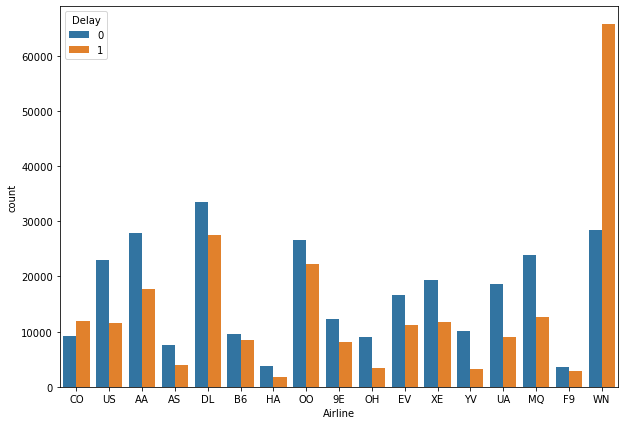

In [99]:
plt.figure(figsize=(10,7))
sns.countplot(master_df['Airline'],hue=master_df['Delay'])
plt.show()

In [100]:
def percent_Delay(x):
    return round(x.sum()/x.size * 100,2)

In [101]:
master_df.groupby('Airline')['Delay'].agg(percent_Delay)

Airline
9E    39.78
AA    38.84
AS    33.93
B6    46.70
CO    56.58
DL    45.05
EV    40.20
F9    44.92
HA    32.02
MQ    34.80
OH    27.83
OO    45.44
UA    32.39
US    33.60
WN    69.78
XE    37.90
YV    24.37
Name: Delay, dtype: float64

Here we can see that Southwest Airlines has around 70 % of Flight delays.

In [102]:
delay_perc = master_df.groupby('Airline')['Delay'].agg(percent_Delay)
delay_perc = delay_perc.reset_index()
delay_perc

,Airline,Delay
0,9E,39.78
1,AA,38.84
2,AS,33.93
3,B6,46.70
4,CO,56.58
5,DL,45.05
6,EV,40.20
7,F9,44.92
8,HA,32.02
9,MQ,34.80


In [103]:
delay_data = pd.merge(delay_perc,airline_dict,left_on="Airline",right_on="Airlines ID", how='left')[['Airline','Delay','Description']]
delay_data

,Airline,Delay,Description
0,9E,39.78,Endeavor
1,AA,38.84,American Airlines
2,AS,33.93,Alaska
3,B6,46.70,Jetblue
4,CO,56.58,United Airlines (initially CO)
5,DL,45.05,Delta
6,EV,40.20,ExpressJet
7,F9,44.92,Frontier
8,HA,32.02,Hawaiian
9,MQ,34.80,Envoy


We have DayOfWeek in our dataset. Flights were delayed on various weekdays. Which day of the week is the safest for travel.

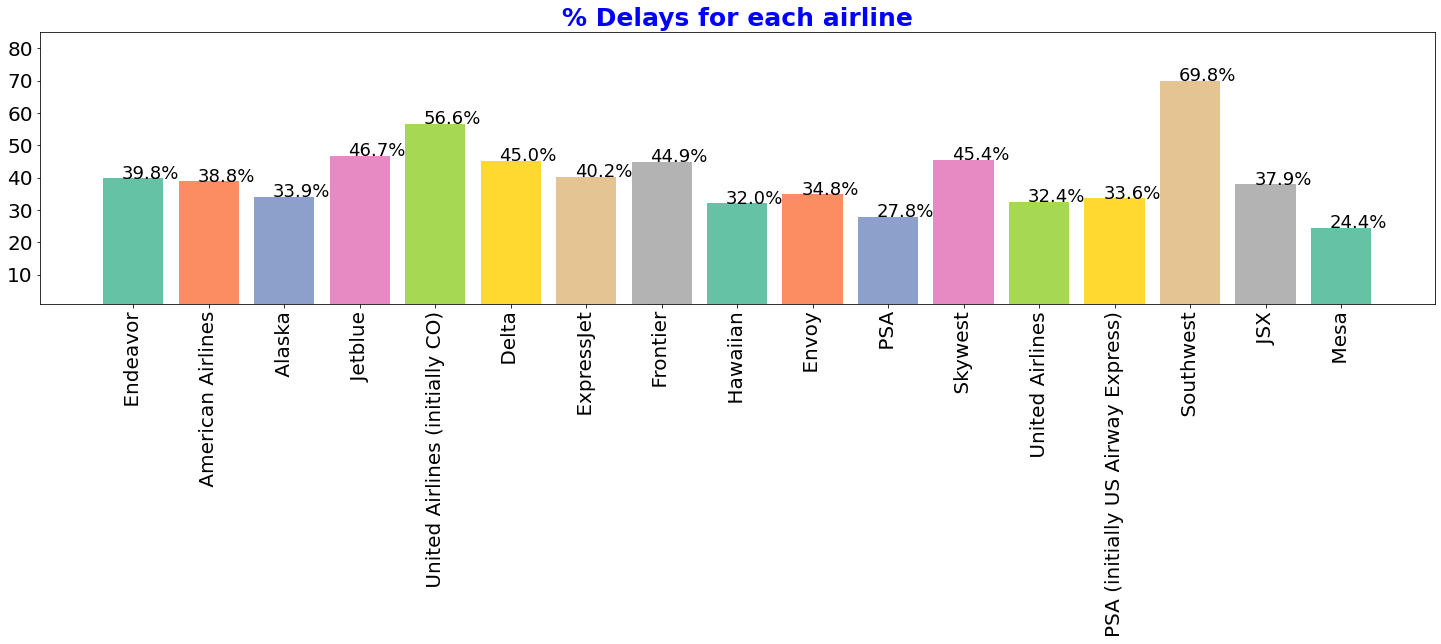

In [104]:
# Plotting a bar chart for a comparative view of delays in all the airlines vs the SouthWest Airlines.xlsx
plt.figure(figsize=(25,5))
plt.bar(delay_data.Description, height = delay_data.Delay, color = plt.get_cmap('Set2').colors, align='center')
for v, idx in zip(delay_data.Delay.values, delay_data.index):
    plt.annotate('{:.1f}%'.format(v), xy=(idx-0.15,v), size =18)
plt.ylim(1,85)
plt.xticks(size=20, rotation=90)
plt.yticks(size=20)
plt.title('% Delays for each airline', size=25, color='blue', weight='heavy')
plt.show()
            

> - **Southwest Airllines has MAX delay about 70%**
> - **Mesa Airlines has less delay**

In [105]:
weekday_df=master_df[['DayOfWeek','Delay']].value_counts().reset_index()

<AxesSubplot:xlabel='DayOfWeek', ylabel='0'>

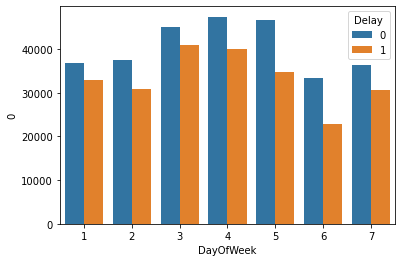

In [106]:
sns.barplot(weekday_df['DayOfWeek'],weekday_df[0],hue=weekday_df['Delay'])

In [107]:
master_df['DayOfWeek'].value_counts()

4    87583
3    86101
5    81413
1    69693
2    68422
7    66908
6    56097
Name: DayOfWeek, dtype: int64

In [108]:
master_df['DayOfWeek'].value_counts()/len(master_df)*100

4    16.966315
3    16.679226
5    15.771081
1    13.500718
2    13.254503
7    12.961216
6    10.866942
Name: DayOfWeek, dtype: float64

In [109]:
delay_each_day =  master_df.groupby('DayOfWeek')['Delay'].apply(percent_Delay).reset_index()
delay_each_day

,DayOfWeek,Delay
0,1,47.28
1,2,45.25
2,3,47.63
3,4,45.84
4,5,42.58
5,6,40.57
6,7,45.77


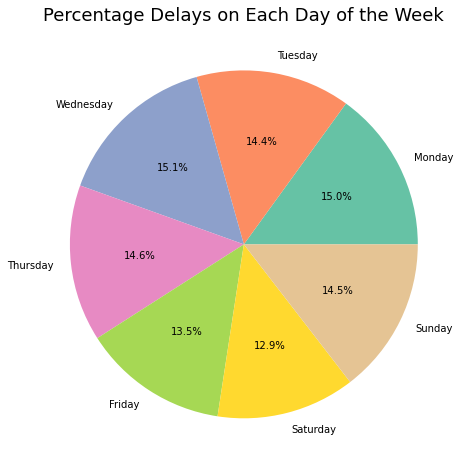

In [110]:
# Data for the pie chart
day_numbers = delay_each_day['DayOfWeek']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
values = delay_each_day['Delay'].values

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=day_names, autopct='%.1f%%', colors=plt.get_cmap('Set2').colors)

# Adding a title
plt.title('Percentage Delays on Each Day of the Week', size=18)

# Displaying the pie chart
plt.show()

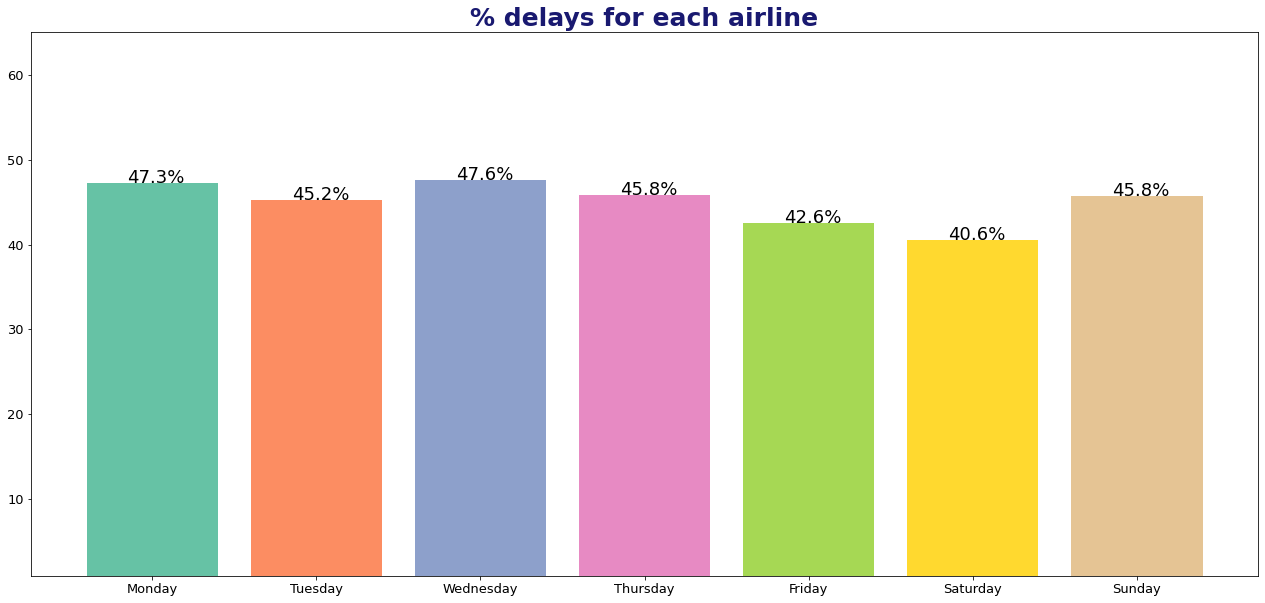

In [111]:
plt.figure(figsize = (22,10))
plt.bar(delay_each_day['DayOfWeek'], height = delay_each_day['Delay'].values, color = plt.get_cmap('Set2').colors)
for v, idx in zip(delay_each_day['Delay'].values, range(1, len(delay_each_day['DayOfWeek'])+1)):
    plt.annotate('{:.1f}%'.format(v), xy = (idx-0.15, v), size = 18)
plt.ylim(1,65)
plt.xticks(range(1, len(delay_each_day['DayOfWeek'])+1), day_names, size=13)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy')
plt.show()

> **Sataurday and friday have less delay**

__We also have length of flight in our dataset,
Lets check which airlines should be recommended for short-, medium-, and long-distance travel__

In [112]:
duration_data = master_df[['Airline', 'Length', 'Delay']].copy()

In [113]:
duration_data['duration'] = pd.cut(duration_data.Length, 3, labels = ['short', 'medium', 'long'])
duration_data_grp = duration_data.groupby(['Airline','duration'])['Delay'].agg(percent_Delay).reset_index().pivot(index = 'Airline', 
                                       columns = 'duration').fillna(0)['Delay']
duration_data_grp.columns = duration_data_grp.columns.astype(str)
duration_data_grp.reset_index()

duration,Airline,short,medium,long
0,9E,39.78,0.00,0.00
1,AA,37.61,43.25,60.40
2,AS,32.58,38.17,0.00
3,B6,45.70,51.05,0.00
4,CO,52.82,64.95,66.87
5,DL,43.87,50.24,48.62
6,EV,40.20,50.00,0.00
7,F9,45.04,43.56,0.00
8,HA,30.16,40.48,0.00
9,MQ,34.81,27.42,0.00


In [114]:
airline_dict.Description = airline_dict.Description.str.strip()
duration_data_grp = pd.merge(duration_data_grp,airline_dict[['Airlines ID', 'Description']],
                             left_on = 'Airline', right_on = 'Airlines ID', how = 'left')
duration_data_grp

,short,medium,long,Airlines ID,Description
0,39.78,0.00,0.00,9E,Endeavor
1,37.61,43.25,60.40,AA,American Airlines
2,32.58,38.17,0.00,AS,Alaska
3,45.70,51.05,0.00,B6,Jetblue
4,52.82,64.95,66.87,CO,United Airlines (initially CO)
5,43.87,50.24,48.62,DL,Delta
6,40.20,50.00,0.00,EV,ExpressJet
7,45.04,43.56,0.00,F9,Frontier
8,30.16,40.48,0.00,HA,Hawaiian
9,34.81,27.42,0.00,MQ,Envoy


In [115]:
long = duration_data_grp[duration_data_grp.long == duration_data_grp.long.min()].Description.values.tolist()
print('Airlines with no delays for long flights :\n',', '.join(long))
medium = duration_data_grp[duration_data_grp.medium == duration_data_grp.medium.min()].Description.values.tolist()
print('\nAirlines with no delays for medium flights :\n', ', '.join(medium))
short = duration_data_grp[duration_data_grp.short == duration_data_grp.short.min()].Description.values.tolist()
print('\nAirlines with no delays for short flights :\n',  ', '.join(short)     )

Airlines with no delays for long flights :
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa

Airlines with no delays for medium flights :
 Endeavor

Airlines with no delays for short flights :
 Mesa


> - **Airlines with no delays for long flights :
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa**
> - **Airlines with no delays for medium flights :
 Endeavor**
> - **Airlines with no delays for short flights :
 Mesa**

Do you notice any patterns in the departure times of long-duration flights. Let's check

In [116]:
master_df['duration'] = pd.cut(master_df.Length, 3, labels = ['short', 'medium', 'long'])
master_df.head(3)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO),short


In [117]:
pd.crosstab(master_df.Time, master_df.duration)['long']

Time
10       0
15       0
20       0
21       0
25       0
30       0
35       0
37       0
40       0
44       0
45       0
48       0
49       0
50       0
55       0
59       0
60       0
70       0
75       0
80       0
85       0
90       0
100      0
110      0
113      0
115      0
120      0
150      0
155      0
165      0
179      0
240      0
259      0
262      0
270      0
300      0
302      0
305      0
310      0
315      0
317      0
320      0
322      0
325      0
327      0
328      0
330      0
331      0
333      0
334      0
335      0
336      0
337      0
338      0
340      0
341      0
342      0
343      0
345      0
346      0
347      0
348      0
349      0
350      0
351      0
352      0
353      0
354      0
355      0
359      0
360      0
361      0
362      0
363      0
364      0
365      0
366      0
367      0
368      0
369      0
370      0
371      0
372      0
373      0
374      0
375      0
376      0
377      0
378      0
379      0
380  

In [118]:
y = pd.crosstab(master_df.Time, master_df.duration)['long'].index
x = pd.crosstab(master_df.Time, master_df.duration)['long'].values

In [119]:
filter_data = master_df.loc[master_df.duration == 'long', ['Time', 'duration']]
filter_data.Time.describe()

count     559.000000
mean      840.635063
std       221.020092
min       540.000000
25%       670.000000
50%       717.000000
75%      1045.000000
max      1310.000000
Name: Time, dtype: float64

Text(0.5, 1.0, 'Histogram of Time')

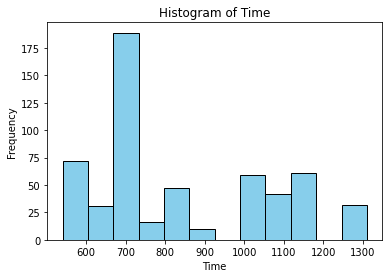

In [120]:
plt.hist(filter_data['Time'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of Time')

Observation : Majority of long distant flights depart in the morning between 5 and 9

_Let's compare how many flights were delayed at large hubs compared to medium hubs_

Text(0.5, 1.0, '% of delay for Source Airport')

findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


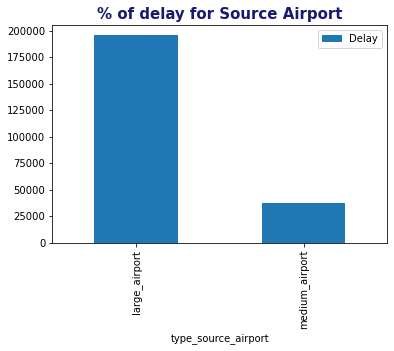

In [121]:
master_df.groupby('type_source_airport')[['Delay']].agg('sum').plot.bar()
plt.title('% of delay for Source Airport', size = 15, color = 'midnightblue', weight = 'heavy', family = 'times')

Text(0.5, 1.0, '% of delay for Destination Airport')

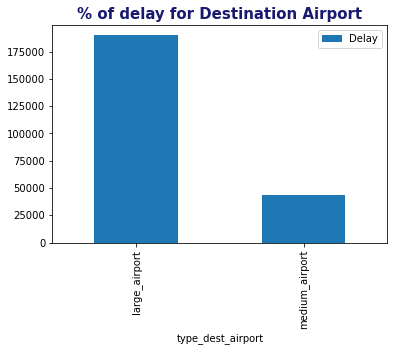

In [122]:
master_df.groupby('type_dest_airport')[['Delay']].agg('sum').plot.bar()
plt.title('% of delay for Destination Airport', size = 15, color = 'midnightblue', weight = 'heavy', family = 'times')

## Hypothesis testing

In [123]:
master_df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'data_2021_source_airport',
       'data_2021_dest_airport', 'Founded', 'Airlines ID', 'Description',
       'duration'],
      dtype='object')

> **(a) If the airport's altitude has anything to do with flight delays for incoming and departing flights**

In [124]:
Ho = "Avg elevation for Delayed flights and not Delayed flights not significantly different"
Ha = "Avg elevation for Delayed flights and not Delayed flights are different"

In [125]:
x = np.array(master_df[master_df['Delay']==1].elevation_ft_source_airport)
x.shape

(233117,)

In [126]:
x

array([  13.,  125.,  152., ..., 2181.,   13.,  125.])

In [127]:
y=np.array(master_df[master_df['Delay']==0].elevation_ft_source_airport)
len(y)

283100

In [128]:
y

array([2181.,  944.,  107., ..., 1026.,   17.,   96.])

In [129]:
t,p_value = ttest_ind(x,y,axis=0)
p_value

1.909387572702128e-19

In [130]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Avg elevation for Delayed flights and not Delayed flights are different as the p_value(1.909387572702128e-19)<0.05


> **For incoming flights**

In [131]:
Ho = "Avg elevation for Delayed flights and not Delayed flights not significantly different"
Ha = "Avg elevation for Delayed flights and not Delayed flights are different"

In [132]:
x = np.array(master_df[master_df['Delay']==1].elevation_ft_dest_airport)
x.shape

(233117,)

In [133]:
y=np.array(master_df[master_df['Delay']==0].elevation_ft_dest_airport)
y

array([  97.,   97.,   97., ...,  620., 1135.,    9.])

In [134]:
t,p_value = ttest_ind(x,y,axis=0)
p_value

2.7948729392515513e-21

In [135]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Avg elevation for Delayed flights and not Delayed flights are different as the p_value(2.7948729392515513e-21)<0.05


>**(b) If the number of runways at an airport affects flight delays.**

_For Outgoing Flights_

In [136]:
Ho = "Number of runways at an airport does not affects flight delays"
Ha = "Number of runways at an airport definetly affects flight delays"

In [137]:
x = np.array(master_df[master_df['Delay']==1].runway_count_source_airport)
y = np.array(master_df[master_df['Delay']==0].runway_count_source_airport)

In [138]:
t,p_value = ttest_ind(x,y,axis=0)
p_value

4.208877752611582e-97

In [139]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Number of runways at an airport definetly affects flight delays as the p_value(4.208877752611582e-97)<0.05


_For Incoming Flights_

In [140]:
Ho = "Number of runways at an airport does not affects flight delays"
Ha = "Number of runways at an airport definetly affects flight delays"
x = np.array(master_df[master_df['Delay']==1].runway_count_dest_airport)
y = np.array(master_df[master_df['Delay']==0].runway_count_dest_airport)
t,p_value = ttest_ind(x,y,axis=0)
p_value

0.0

In [141]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Number of runways at an airport definetly affects flight delays as the p_value(0.0)<0.05


>**(c) If the duration of a flight (length) affects flight delays**

In [142]:
Ho = "Duration of a flight (length) does not affects flight delays"
Ha = "Duration of a flight (length) affects flight delays"

In [143]:
x = np.array(master_df[master_df['Delay']==1].Length)
y = np.array(master_df[master_df['Delay']==0].Length)

In [144]:
t,p_value = ttest_ind(x,y,axis=0)
p_value

3.1017334192639697e-183

In [145]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Duration of a flight (length) affects flight delays as the p_value(3.1017334192639697e-183)<0.05


### Correlation Matrix

In [146]:
corr_matrix = master_df.corr()
corr_matrix

,id,Flight,DayOfWeek,Time,Length,Delay,elevation_ft_source_airport,runway_count_source_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
id,1.000000,-0.006202,-0.055079,0.028489,0.020984,0.140434,0.003951,-0.003162,0.003102,-0.009681,0.001413,-0.006596,0.009168
Flight,-0.006202,1.000000,0.001468,-0.001958,-0.346860,-0.057371,0.141999,0.012212,0.144422,0.013726,-0.057604,-0.055514,0.434772
DayOfWeek,-0.055079,0.001468,1.000000,0.001092,0.013248,-0.025832,0.001177,0.000033,0.000999,-0.000335,0.004348,0.004086,-0.005205
Time,0.028489,-0.001958,0.001092,1.000000,-0.020629,0.149801,0.013952,0.091551,-0.010090,-0.115846,0.124940,-0.128100,0.004272
Length,0.020984,-0.346860,0.013248,-0.020629,1.000000,0.040162,-0.086144,0.050683,-0.050448,0.090177,0.099080,0.158028,-0.332935
Delay,0.140434,-0.057371,-0.025832,0.149801,0.040162,1.000000,0.012551,0.029099,0.013180,-0.061431,0.020300,-0.051628,-0.002103
elevation_ft_source_airport,0.003951,0.141999,0.001177,0.013952,-0.086144,0.012551,1.000000,0.095883,0.231182,-0.017638,0.162757,-0.022220,0.020167
runway_count_source_airport,-0.003162,0.012212,0.000033,0.091551,0.050683,0.029099,0.095883,1.000000,-0.018412,-0.212869,0.615643,-0.242409,-0.101429
elevation_ft_dest_airport,0.003102,0.144422,0.000999,-0.010090,-0.050448,0.013180,0.231182,-0.018412,1.000000,0.095766,-0.024062,0.162708,0.019975
runway_count_dest_airport,-0.009681,0.013726,-0.000335,-0.115846,0.090177,-0.061431,-0.017638,-0.212869,0.095766,1.000000,-0.240876,0.615660,-0.100473


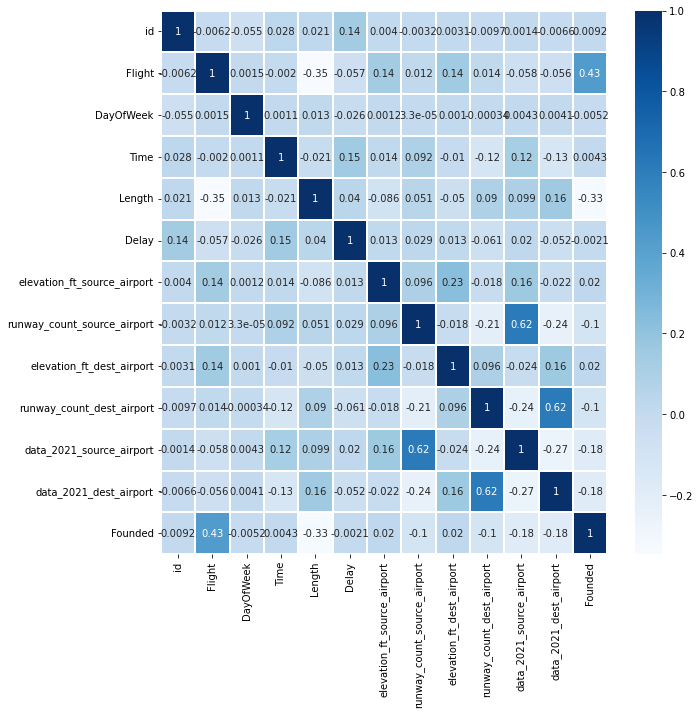

In [147]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='Blues',linecolor='white', linewidths=2, annot=True)
plt.show()

### Model Building

In [148]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516217 entries, 0 to 516216
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   id                           516217 non-null  int64   
 1   Airline                      516217 non-null  object  
 2   Flight                       516217 non-null  int64   
 3   AirportFrom                  516217 non-null  object  
 4   AirportTo                    516217 non-null  object  
 5   DayOfWeek                    516217 non-null  int64   
 6   Time                         516217 non-null  int64   
 7   Length                       516217 non-null  int64   
 8   Delay                        516217 non-null  int64   
 9   type_source_airport          516217 non-null  object  
 10  elevation_ft_source_airport  516217 non-null  float64 
 11  runway_count_source_airport  516217 non-null  float64 
 12  type_dest_airport            516217 non-null

In [149]:
master_df2=master_df.drop(columns = ['id', 'Flight',  'duration','Airline', 'AirportFrom', 'AirportTo'])
master_df2.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description
0,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO)
1,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO)
2,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO)
3,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO)
4,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO)


In [150]:
master_df2.drop(columns = ['Airlines ID', 'Description'], inplace = True)
master_df2.head(3)

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0
2,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0


In [151]:
master_df2.type_dest_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [152]:
master_df2.type_source_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [153]:
ordinal = OrdinalEncoder(categories=[['medium_airport', 'large_airport'],['medium_airport', 'large_airport']])
ordinal.fit(master_df2[['type_source_airport', 'type_dest_airport']])

OrdinalEncoder(categories=[['medium_airport', 'large_airport'],
                           ['medium_airport', 'large_airport']])

In [154]:
master_df2[['type_source_airport', 'type_dest_airport']] = ordinal.transform(master_df2[['type_source_airport', 'type_dest_airport']])

In [155]:
master_df2.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,1934.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,1934.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,1934.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,1934.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,1934.0


In [156]:
master_df2['years_of_operation'] = 2023 - master_df2['Founded']

In [157]:
master_df2.drop(['Founded'],axis=1,inplace=True)
master_df2.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,years_of_operation
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,89.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,89.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,89.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,89.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,89.0


In [158]:
master_df.shape

(516217, 21)

Now our data is ready for model building

In [159]:
model_df = master_df2.copy()
model_df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,years_of_operation
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,89.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,89.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,89.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,89.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,89.0


In [160]:
X = model_df.drop(['Delay'],axis=1)
y = model_df.Delay

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(412973, 12)
(103244, 12)
(412973,)
(103244,)


### Logistic Regression

In [163]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [164]:
from sklearn.model_selection import RandomizedSearchCV

In [165]:
params = {
    "penalty": ['l1', 'l2'],
    "solver": ['newton-cg', 'liblinear']
}

# Cross Validation
folds = 5

rscv = RandomizedSearchCV(
    estimator=lr,
    param_distributions=params,
    scoring="accuracy",
    verbose=1,
    cv=folds
)

rscv.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'liblinear']},
                   scoring='accuracy', verbose=1)

In [166]:
rscv.best_params_

{'solver': 'liblinear', 'penalty': 'l1'}

In [167]:
rscv.best_score_

0.5725967601437488

In [168]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [169]:
lr.score(X_test,y_test)

0.5721204137770718

### DecisionTree Classifier

In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

dt = DecisionTreeClassifier()

random_search = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'entropy'}
Best Score: 0.6393614209214755


In [171]:
dtc = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=15, criterion='entropy')

In [172]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_leaf=2)

In [173]:
dtc.score(X_train,y_train)

0.6733055187627278

DecisionTree has good accuracy

### XGB

In [174]:
#!pip install xgboost

In [175]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2],
}

# Create an XGBClassifier object
xgb = XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'subsample': 0.5, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5}
Best Score: 0.6600697860697913


In [176]:
xgb=XGBClassifier(subsample= 0.5, min_child_weight= 1, max_depth= 7, learning_rate= 0.2, gamma= 0, colsample_bytree= 0.5)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [177]:
xgb.score(X_train,y_train)

0.6755889610216649

In [178]:
print(lr.score(X_test,y_test))
print(dtc.score(X_test,y_test))
print(xgb.score(X_test,y_test))

0.5721204137770718
0.6389039556778118
0.6596315524388826
